<a href="https://colab.research.google.com/github/ribesstefano/GPU-accelerated-Finite-Element-Method-using-Python-and-CUDA/blob/main/TRA105_GPU_accelerated_Computational_Methods_using_Python_and_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This report document describes the work done within the course _TRA105 - GPU-accelerated Computational Methods using Python and CUDA_, held at Chalmers University.
The main contributions are given by Stefano Ribes, who developed all the high performance code, Kim Louisa Auth, who wrote an initial version of the FEM algorithm, and Fredrik Larsson, who supervised the project.

This document is a PDF version of the Jupyter Notebook used to develop, test, and evaluate the proposed software. In the first part, we describe the FEM algorithm from a higher point of view. We then report a simple mechanism to generate "large enough" FEM problems. Then, we proceed to evaluate different solver strategies and select the best performing solver algorithm.
At this point, we present three different implementation of the K-assembly step in the FEM algorithm. An additional K-assembly implementation based on cell coloring is proposed in the Appendix as a work in progress.
In the end, we show an evaluation of the three different proposed K-assembly steps, before drawing our conclusions.

# Code Setup

This section installs the necessary dependencies and downloads the [Github repository](https://github.com/ribesstefano/GPU-accelerated-Finite-Element-Method-using-Python-and-CUDA).

In order to run this notebook, please change the runtime type to GPU.

# Methodology

In this section, we cover our methodology, showing the implemented functions and algorithms to accelerate the FEM algorithm computation.

In [1]:
!pip install --upgrade matplotlib==3.4.0 -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 97.1 MB/s eta 0:00:00


In [2]:
repository = 'GPU-accelerated-Finite-Element-Method-using-Python-and-CUDA'
!git clone https://github.com/ribesstefano/{repository}.git

Cloning into 'GPU-accelerated-Finite-Element-Method-using-Python-and-CUDA'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 179 (delta 99), reused 137 (delta 73), pack-reused 0
Receiving objects: 100% (179/179), 1.45 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [3]:
!pip install pygmsh -qqq
!pip install --upgrade scipy -qqq
!pip install --upgrade --no-cache-dir gdown -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.4 MB/s eta 0:00:00


In [4]:
%%capture
%cd {repository}

from BasicFEM import *
# Math and SciPy
import math
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import coo_matrix
# Profiling
import time
import timeit
import cProfile
import pstats
# Plotting
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
# Acceleration
# !NUMBA_ENABLE_CUDASIM=1 # To run CUDA in simulation mode 
import numpy as np
import numba as nb
from numba import njit, prange
from numba.typed import Dict
from numba.core import types
from numba.types import float32

%cd ..

## FEM Problem Implementation

In this section we define and visualize a simple FEM problem and its mesh, _i.e._, grid.

The analyzed grid is defined as a mesh of 2D triangular cell elements, each referencing three nodes IDs. Each node is defined in a 2D coordinate system. We also limit our problem to two Degree of Freedom (DoF) per node.
The length characteristic `lcar` of a grid can be adjusted in order to generate grids with different numbers of cells.

We can create such a grid with the function `generate_grid`. The function exploits the Pygmsh Python library. The library  does show some limitations and bugs, and it's not ideal for generating large meshes. Nevertheless, it is a convenient way for checking the correctness of our implementation.

A DoF handler object is instantiated given a grid and represents a useful wrapper of the FEM problem.

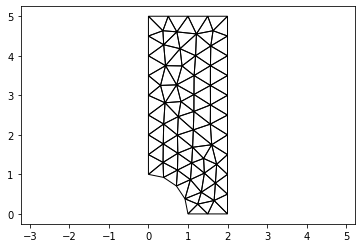

In [5]:
grid = generate_grid(lcar=0.5)
dh = DofHandler(n_dofs_per_node=2, grid=grid)
grid.plot()

The DoF handler allows us to define the _nodal forces_ vector $a$. The $y$ components of the top DoFs are set to $-0.1^{[2]}$.

[2] Due to the limitations mentioned earlier, Pygmsh is unable to correctly identify all top DoFs. Because of that, the resulting nodal displacements will appear wrong in the top right corner. We haven't implemented a work-around for this issue, but we believe that such missing information would not make our implementation lose generality.

In [6]:
top_dofs = dh.get_nodes_dofs(grid.nodesets['top'])
a = np.zeros(dh.get_ndofs_total())
a[top_dofs[:, 1]] = -0.1
a

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. , -0.1,  0. , -0.1,  0. , -0.1,  0. , -0.1,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ])

The DoF handler can also be used to extract the non-zero indexes of the global stiffness matrix $K$. Once the indexes are now, an empty Scipy sparse matrix can be instantiated.

In [7]:
def init_Kf(dh, as_dok=False):
    if as_dok:
        row_idx, col_idx, K_shape = dh.get_sparsity_pattern(return_shape=True)
        K = scipy.sparse.dok_matrix(K_shape, dtype=np.float32)
    else:
        row_idx, col_idx = dh.get_sparsity_pattern()
        K = scipy.sparse.csr_matrix((np.zeros(len(row_idx)), (row_idx, col_idx)))
    f = np.zeros(len(row_idx))
    return K, f

K, f = init_Kf(dh)

Finally, we can wrap all the above information in a single function generating our selected FEM problem, accordingly.

In [8]:
def generate_fem_problem(lcar=0.1, return_Kf=False, as_dok=False, grid=None,
                         dh=None):
    if grid is None and dh is None:
        grid = generate_grid(lcar)
    if dh is None:
        dh = DofHandler(n_dofs_per_node=2, grid=grid)
    # Prescribe a vector
    a = np.zeros(dh.get_ndofs_total())
    bottom_dofs = dh.get_nodes_dofs(dh.grid.nodesets['bottom'])
    left_dofs = dh.get_nodes_dofs(dh.grid.nodesets['left'])
    top_dofs = dh.get_nodes_dofs(dh.grid.nodesets['top'])
    prescribed_dofs = (bottom_dofs[:, 1], left_dofs[:, 0], top_dofs[:, 1])
    prescribed_dofs = np.concatenate(prescribed_dofs)
    free_dofs = np.setdiff1d(range(dh.get_ndofs_total()), prescribed_dofs)
    a[top_dofs[:, 1]] = -0.1
    dofs = {
        'bottom': bottom_dofs,
        'left': left_dofs,
        'top': top_dofs,
        'prescribed': prescribed_dofs,
        'free': free_dofs,
    }
    # Init weak form handler
    weak_form = MomentumBalance(material=Elasticity(E=200e3, nu=0.3),
                                thickness=1.0,
                                element=CST())
    if return_Kf:
        # Init K and f components
        K, f = init_Kf(dh, as_dok)
        return K, f, a, weak_form, dh, dofs
    else:
        return a, weak_form, dh, dofs

a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.5)

### Generating Large Meshes

The problem defined above is easy to investigate and therefore useful for inspecting the correctness of the different variations of our analysis.

However, for testing our implementation for very large problems, _i.e._, when having a number of cells in the order of millions, we developed a function to generate random coordinates and then triangulate them via [Delaunay triangulation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html).

In order to speed up some parts of the generation, we rely on Numba JIT compilation.
To start with, we define as global variables the constant parameters of the FEM problem, _e.g._, the number of DoF per node. This will allow us for better handling of the array sizes within the jitted Numba functions.

In [9]:
a, weak_form, dh, dofs = generate_fem_problem(lcar=0.5)

n_dims = dh.grid.n_dim
n_nodes_per_cell = dh.grid.get_num_nodes_per_cell()
n_dofs_per_cell = dh.get_ndofs_per_cell()
n_dofs_per_node = dh.n_dofs_per_node
stiffness_shape = weak_form.material.stiffness.shape
weights_shape = weak_form.element.weights.shape

Next, in order to populate the DoF information, we designed a custom Numba function `get_cells_dofs`. Note the use of `prange`: each cell can be processed independently, so we hint the compiler to parallelize over that dimension, _i.e._, axis.

In [41]:
@nb.jit(nopython=True, cache=True, parallel=True)
def get_cells_dofs(cells, n_dofs_per_cell=n_dofs_per_cell, n_dofs=n_dofs_per_node):
    n_cells = cells.shape[0]
    dofs = np.empty((n_cells, n_dofs_per_cell), dtype=np.int32)
    for i in prange(n_cells):
        for j, nodeid in enumerate(cells[i]):
                for d in range(n_dofs):
                    dofs[i, j * n_dofs + d] = nodeid * n_dofs + d
    return dofs

Finally, the function is used to generate the FEM problems. The information about the grid, such as nodes coordinates, triangulation and sets, is stored on disk to be reused across multiple runs.

In [42]:
from scipy.spatial import Delaunay
import os

def generate_rand_fem_problem(n_nodes=int(3e3), filename='randgrid.npz'):
    """
    If supplied, read filename containing compressed Numpy array.
    """
    if os.path.isfile(filename):
        print(f'File {filename} loaded.')
        data = np.load(filename)
        nodes = data['nodes']
        cells = data['cells']
        nodesets = {
            'bottom': data['bottom'],
            'left': data['left'],
            'top': data['top'],
        }
    else:
        nodes = np.random.rand(n_nodes, n_dims).astype(np.float32)
        cells = Delaunay(nodes).simplices.astype(np.int32)
        set_sz = int(0.2 * n_nodes)
        nodesets = {
            'bottom': np.random.choice(np.arange(n_nodes), size=set_sz).astype(np.int32),
            'left': np.random.choice(np.arange(n_nodes), size=set_sz).astype(np.int32),
            'top': np.random.choice(np.arange(n_nodes), size=set_sz).astype(np.int32),
        }
        np.savez_compressed(filename, nodes=nodes, cells=cells,
                            bottom=nodesets['bottom'],
                            left=nodesets['left'],
                            top=nodesets['top'])
    # Generate small mesh to be overwritten
    grid = generate_grid(lcar=0.9)
    dh = DofHandler(n_dofs_per_node=2, grid=grid)
    # Update grid and dh with a much bigger random problem
    dh.grid = Grid(nodes, cells, nodesets)
    dh.cells_dofs = get_cells_dofs(dh.grid.cells)
    # Generate the rest of the components
    return generate_fem_problem(dh=dh)

a, weak_form, dh, dofs_glob = generate_rand_fem_problem(n_nodes=int(3e3))

File randgrid.npz loaded.


## Solver Evaluation

We begin by identifying the best performing solver algorithm among the available ones provided by the SciPy and CuPy packages. For brevity, here we only report the final evaluation results, but the code implementation can be inspected at this [link](https://github.com/ribesstefano/GPU-accelerated-Finite-Element-Method-using-Python-and-CUDA/blob/main/test/profile_gpu_solvers.py).

In [10]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(repository, 'data', 'solver_evaluation_results.csv'))

df['K dimensions'] = df['n_nodes'] * n_dofs_per_node
df['Normalized Execution Time'] = df['Execution Time [s]']
# NOTE: The cgs solver is just too much of an outsider, so we remove it
df = df.drop(df[df['Solver'] == 'cgs'].index)

for n_cells in df['Number of Cells'].unique():
    selected_cells = df['Number of Cells'] == n_cells
    exec_t = df.loc[selected_cells, 'Execution Time [s]']
    max_t = df.loc[selected_cells, 'Execution Time [s]'].max()
    df.loc[selected_cells, 'Normalized Execution Time'] /= max_t

df_cpu = df[df['Device'] == 'Xeon']
df_gpu = df[df['Device'] == 'GTX 1050']
df

,Solver,lcar,n_nodes,Number of Cells,n_runs,Device,Execution Time [s],K dimensions,Normalized Execution Time
0,spsolve,0.50,29,38,20,Xeon,0.0001,58,0.001739
1,bicg,0.50,29,38,20,Xeon,0.0017,58,0.029565
2,bicgstab,0.50,29,38,20,Xeon,0.0012,58,0.020870
3,cg,0.50,29,38,20,Xeon,0.0010,58,0.017391
5,gmres,0.50,29,38,20,Xeon,0.0013,58,0.022609
6,lgmres,0.50,29,38,20,Xeon,0.0030,58,0.052174
7,minres,0.50,29,38,20,Xeon,0.0013,58,0.022609
8,qmr,0.50,29,38,20,Xeon,0.0019,58,0.033043
9,gcrotmk,0.50,29,38,20,Xeon,0.0021,58,0.036522
10,tfqmr,0.50,29,38,20,Xeon,0.0018,58,0.031304


In order to better visualize and compare different solvers' performance across different grid characteristic lenghts, the execution time as been normalized to the slowest recorded time.

The following figure shows the solver algorithm performance running on a 8 cores Intel Xeon CPU processor.

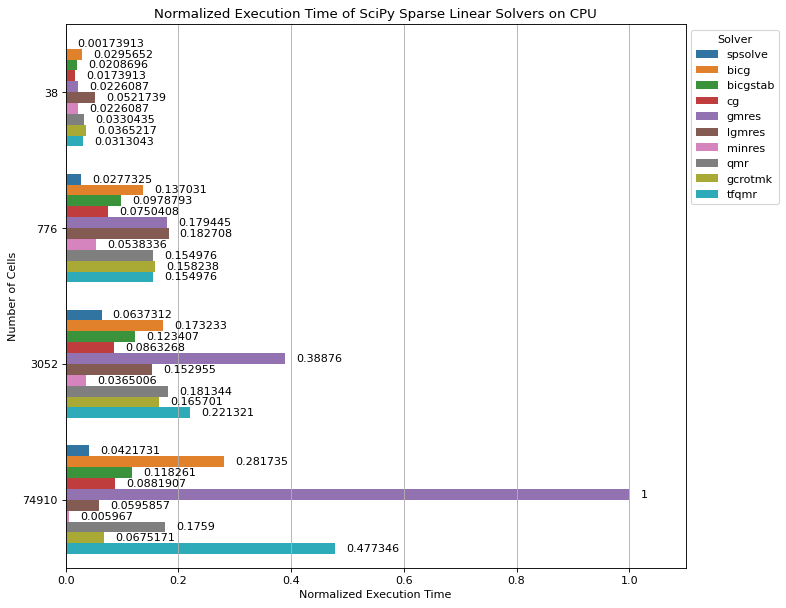

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='r')

ax = sns.barplot(data=df_cpu, y='Number of Cells',
                 x='Normalized Execution Time', hue='Solver', orient='h')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

for container in ax.containers:
    ax.bar_label(container, padding=10)

plt.grid(axis='x')
plt.xlim([0, 1.1])
plt.title(f'Normalized Execution Time of SciPy Sparse Linear Solvers on CPU')
# plt.savefig(f'solvers_exec_time_cpu.png', bbox_inches='tight')
plt.show()

We can now plot the normalized execution time of the different solvers running on a Nvidia GTX 1050 GPU. 

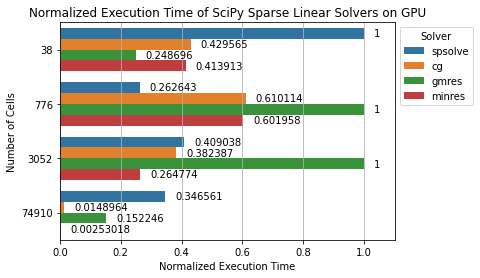

In [12]:
# figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='r')

ax = sns.barplot(data=df_gpu, y='Number of Cells',
                 x='Normalized Execution Time', hue='Solver', orient='h')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

for container in ax.containers:
    ax.bar_label(container, padding=10)

plt.grid(axis='x')
plt.xlim([0, 1.1])
plt.title(f'Normalized Execution Time of SciPy Sparse Linear Solvers on GPU')
# plt.savefig(f'solvers_exec_time_cpu.png', bbox_inches='tight')
plt.show()

As we can see, for both devices, the `minres` solver is the best performing one, especially in the case of large matrix dimensions. We believe that the main reason for such result lies in the fact that `minres` is able to best leverage the symmetry and the sparseness of the stiffness matrix compared to the other solver algorithms.

## K-Assembly Implementation

We now show different implementations for the K-assembly step. Given the chosen FEM problem, the stiffness matrix K is sparse by construction. This allows us to leverage different strategies for storing it.

There exist several ways for storing sparse matrices, each with its own trade-offs. the Compressed Sparse Row (CSR) format, for instance, is well suited for efficient matrix computations, but it's not for accessing individual elements via indexing. This limitation can be overcome by the [COOrdinate (COO) format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix): in practice three arrays contain the non-zero elements, rows, and columns indexes, respectively, of the matrix.

Although not being optimal in terms of storage size, the SciPy and CuPy COO implementations have the advantage of automatically handle duplicate entries, _i.e._, at same coordinates, by summing them. This mechanism avoids manual handling of the reduction of the elements stiffness matrixes which share nodes together.
Because of that, we decided to adopt the COO format during the assembly of the stiffness matrix, before converting it to CSR format for the subsequent solving step.

In the following analysis, we solve the full FEM problem exploiting the MINRES solver algorithm.

<!-- It allows fast indexing ($O(1)$ complexity) and  -->

### Naive K-Assembly on CPU

The naive K-assembly implementation mainly consists of a loop over each cell element. As expected, it is not well performant.

In [13]:
@nb.jit(nopython=True, cache=True, parallel=True)
def get_coo_indices(dofs):
    block_sz, n_dofs_per_cell = dofs.shape
    f_rows = np.empty(dofs.shape, dtype=np.int32)
    f_cols = np.zeros(dofs.size, dtype=np.int32)
    K_rows = np.empty((block_sz, n_dofs_per_cell, n_dofs_per_cell), dtype=np.int32)
    K_cols = np.zeros((block_sz, n_dofs_per_cell, n_dofs_per_cell), dtype=np.int32)
    for k in prange(block_sz):
        for i, dof_i in enumerate(dofs[k]):
            f_rows[k, i] = dof_i
            for j, dof_j in enumerate(dofs[k]):
                K_rows[k, i, j] = dof_i
                K_cols[k, i, j] = dof_j
    return (K_rows.flatten(), K_cols.flatten()), (f_rows.flatten(), f_cols.flatten())

def naive_k_assembly_cpu(a, weak_form, dh, grid=None):
    if grid is None:
        grid = dh.grid
    # Init element matrices
    ndofs_cell = dh.get_ndofs_per_cell()
    ke = np.zeros((ndofs_cell, ndofs_cell), dtype=np.float32)
    re = np.zeros(ndofs_cell, dtype=np.float32)
    # Setup K matrix and f vector in COO format
    K_data, K_rows, K_cols = [], [], []
    f_data, f_rows, f_cols = [], [], []
    # Assemble K and f components
    for cellid in range(grid.get_num_cells()):
        ke.fill(0.0)
        re.fill(0.0)
        xe = grid.get_coordinates(cellid)
        dofs = dh.get_cell_dofs(cellid)
        ue = a[dofs] # NOTE: Not relevant as input for linear elasticity
        weak_form.run_element_routine(ke, re, xe, ue)
        K_tmp, f_tmp = get_coo_indices(dofs[None])
        # Update K matrix components
        K_data.extend(ke.flatten())
        K_rows.extend(K_tmp[0])
        K_cols.extend(K_tmp[1])
        # Update f vector components
        f_data.extend(re.flatten())
        f_rows.extend(f_tmp[0])
        f_cols.extend(f_tmp[1])
    # Convert lists to COO matrices
    # NOTE: Components at same indeces are automatically accumulated together
    K_data = np.array(K_data, dtype=np.float32).flatten()
    K_rows = np.array(K_rows, dtype=np.int32).flatten()
    K_cols = np.array(K_cols, dtype=np.int32).flatten()
    K = coo_matrix((K_data, (K_rows, K_cols)), dtype=np.float32)
    f_data = np.array(f_data, dtype=np.float32).flatten()
    f_rows = np.array(f_rows, dtype=np.int32).flatten()
    f_cols = np.array(f_cols, dtype=np.int32).flatten()
    f = coo_matrix((f_data, (f_rows, f_cols)), dtype=np.float32).toarray()
    return K, f

In [14]:
def run_solver(K, f, a, dofs, solver=scipy.sparse.linalg.spsolve):
    K_free = K.tocsc()[:, dofs['free']].tocsr()[dofs['free'], :]
    K_prescribed = K.tocsc()[:, dofs['prescribed']].tocsr()[dofs['free'], :]
    f_glob = -K_prescribed @ a[dofs['prescribed']]
    return solver(K_free, f_glob)

In [15]:
a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.5)
# dh.grid.plot(a.reshape(len(dh.grid.nodes), dh.n_dofs_per_node)[:, 1])
K, f = naive_k_assembly_cpu(a, weak_form, dh)
a[dofs_glob['free']], _ = run_solver(K, f, a, dofs_glob, solver=scipy.sparse.linalg.minres)

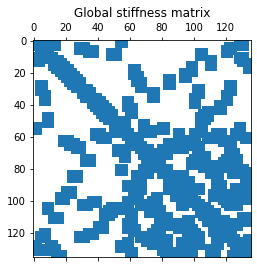

In [16]:
def plot_K(K, filename=None):
    if K.shape[0] < 20000:
        plt.spy(K)
        if filename is not None:
            plt.savefig(filename)
        plt.show()

plt.title('Global stiffness matrix')
plot_K(K)

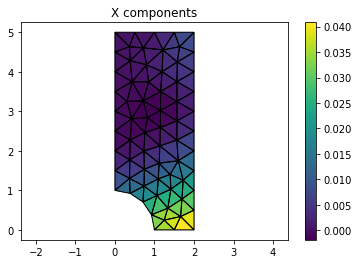

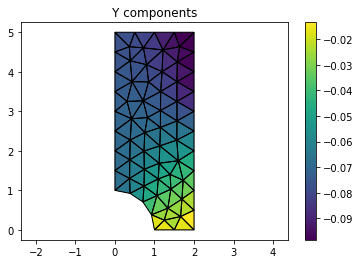

In [17]:
def plot_grid(a, dh):
    if len(dh.grid.nodes) < 2000:
        nodal_effects = a.reshape(len(dh.grid.nodes), dh.n_dofs_per_node).copy()
        plt.title('X components')
        dh.grid.plot(nodal_effects[:, 0])
        plt.title('Y components')
        dh.grid.plot(nodal_effects[:, 1])

plot_grid(a, dh)

### Profiling

This section about code profiling is reported for completeness, but its output is omitted for brevity.

Please note that these two cells execution will take a considerable amount of time to complete, since the implementation is not efficient yet.

In [22]:
# a, weak_form, dh, dofs_glob = generate_rand_fem_problem(filename=f'data/randgrid_n{int(3e3)}.npz')
a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.09)
print(f'Number of cells: {len(dh.grid.cells)}')
print(f'Number of nodes: {len(dh.grid.nodes)}')
K_dim = dh.get_ndofs_total()
print(f'a dimensions: ({K_dim}, 1)')
print(f'K dimensions: ({K_dim}, {K_dim}) (Total elements: {K_dim * K_dim})')

Number of cells: 264199
Number of nodes: 132856
a dimensions: (265712, 1)
K dimensions: (265712, 265712) (Total elements: 70602866944)


In [ ]:
# Reset a, in case this code is called multiple times
a = np.zeros(dh.get_ndofs_total())
a[dofs_glob['top'][:, 1]] = -0.1
# Init profiler
profiler = cProfile.Profile()
profiler.enable()
# Run CPU functions
K, f = naive_k_assembly_cpu(a, weak_form, dh)
a[dofs_glob['free']], _ = run_solver(K, f, a, dofs_glob,
                                     solver=scipy.sparse.linalg.minres)
# Stop profiling
profiler.disable()
# Create statistics from the profiler, sorted by cumulative time
stats = pstats.Stats(profiler).sort_stats('cumtime')
# Print the 10 (inclusive) most expensive functions
stats.print_stats(10)

## Batched K-Assembly on CPU

As for-loops are very inefficient in Python, one optimization strategy is to refactor the code to eliminate explicit for-loop and instead embed them into Numba-optimized functions. In fact, we can take advantage of the fact that the element routine can be run independently on each cell before being eventually accumulated.

### Batched Element Routine on CPU

In the following Numba functions, the vectors are defined with an additional first dimension, which indexes elements in the grid or in a batch. Numba has been utilized to optimize the remaining for-loops in the algorithm.

In [18]:
@nb.guvectorize('(float32[:,:,:], float32[:])', '(b,c,n)->(b)', cache=True, target='parallel')
def jacobi_det_cell3_2D(xe, detJ):
    for i in prange(detJ.shape[0]):
        detJ[i] = ((xe[i, 1, 0] - xe[i, 0, 0]) * (xe[i, 2, 1] - xe[i, 0, 1]) -
                   (xe[i, 2, 0] - xe[i, 0, 0]) * (xe[i, 1, 1] - xe[i, 0, 1]))


def jacobian_cell3_2D(xe, J):
    # TODO(Kim): Not generally constant, could depend on iso_coord (xi)
    J[:, 0, 0] = xe[:, 1, 0] - xe[:, 0, 0]
    J[:, 0, 1] = xe[:, 2, 0] - xe[:, 0, 0]
    J[:, 1, 0] = xe[:, 1, 1] - xe[:, 0, 1]
    J[:, 1, 1] = xe[:, 2, 1] - xe[:, 0, 1]


@nb.jit(nopython=True, cache=True, parallel=True)
def assemble_B(dNdx, B):
    """
    dNdx: (batch_sz, n_nodes_cell, n_dofs_node)
    B: (batch_sz, n_nodes_cell, n_dofs_cell)
    """
    for j in range(dNdx.shape[1]):
        dNidx = dNdx[:, j, 0]
        dNidy = dNdx[:, j, 1]
        B[:, 0, 2 * j] = dNidx
        B[:, 2, 2 * j] = dNidy
        B[:, 1, 2 * j + 1] = dNidy
        B[:, 2, 2 * j + 1] = dNidx

The above functions are then utilized in the following element routine function, which also leverages efficient Numpy functions such as `einsum` and `matmul`. The idea is in fact to convert matrix-vector operations to matrix-matrix operations via _stacking_ all the vectors in a batch.

In [19]:
def batched_element_routine_cpu(stiffness, thickness, weights, xe, ue, ke, re,
                                detJ=None, J=None, B=None, dNdxi=None, dNdx=None):
    batch_sz = xe.shape[0]
    n_dofs_cell = ue.shape[1]
    # Init local variables if not provided
    if detJ is None:
        detJ = np.zeros(batch_sz, dtype=np.float32)
    if J is None:
        J = np.zeros((batch_sz, 2, 2), dtype=np.float32) # Shape: (b, 2, 2)
    if B is None:
        # TODO(Stefano): For now, B doesn't depend on nqp
        nqp = weights.shape[0]
        B = np.zeros((batch_sz, dh.grid.nnodes_per_cell(), n_dofs_cell), dtype=np.float32)
    if dNdxi is None:
        dNdxi = np.array([[-1.0, -1.0], [1.0, 0.0], [0.0, 1.0]], dtype=np.float32) # Shape: (3, 2)
    if dNdx is None:
        dNdx = np.empty((batch_sz, *dNdxi.shape), dtype=np.float32)
    # Get shape of gradients
    jacobi_det_cell3_2D(xe, detJ)
    jacobian_cell3_2D(xe, J)
    JinvT = np.linalg.inv(J).transpose((0, 2, 1))
    dNdx = np.matmul(JinvT, dNdxi.T).transpose((0, 2, 1))
    # Get B
    assemble_B(dNdx, B)
    BT = B.transpose((0, 2, 1))
    # Setup element routine
    detJw = detJ * weights
    dsde = stiffness
    # Run element routine
    epsilon = np.einsum('bij,bj->bi', B, ue)
    sigma = np.einsum('ij,bj->bi', dsde, epsilon)
    BTsigma = np.einsum('bij,bj->bi', BT, sigma)
    BTdsdeB = np.matmul(np.matmul(BT, dsde), B)
    re += BTsigma * detJw[:, None]
    ke += BTdsdeB * detJw[:, None, None]
    re *= thickness
    ke *= thickness

### K-Assembly on CPU

Compared to the naive version, we also introduce a "batched" for-loop: instead of iterating over each cell element, we populate a batch accordingly, before feeding it into the batched element routine function. In order to efficiently populate the batch, we again exploit Numba and elements independence.  

In [20]:
@nb.jit(nopython=True, cache=True, parallel=True)
def get_dofs(nodes, a, dofs, ue):
    """
    Populate the dofs and ue based on the given nodes.

    nodes: shape: (batch_sz, n_nodes_cell)
    dofs: shape: (batch_sz, n_nodes_cell * n_dofs_per_node)
    ue: shape: (batch_sz, n_nodes_cell * n_dofs_per_node)
    """
    batch_sz, n_nodes_cell = nodes.shape
    n_dofs = dofs.shape[-1] // n_nodes_cell
    for i in prange(batch_sz):
        for j, nodeid in enumerate(nodes[i]):
            for k in range(n_dofs):
                dofs[i, j * n_dofs + k] = nodeid * n_dofs + k
        ue[i] = a[dofs[i]]

@nb.jit(nopython=True, cache=True, parallel=True)
def get_coo_indices(dofs):
    batch_sz, n_dofs_per_cell = dofs.shape
    f_rows = np.empty(dofs.shape, dtype=np.int32)
    f_cols = np.zeros(dofs.size, dtype=np.int32)
    K_rows = np.empty((batch_sz, n_dofs_per_cell, n_dofs_per_cell), dtype=np.int32)
    K_cols = np.zeros((batch_sz, n_dofs_per_cell, n_dofs_per_cell), dtype=np.int32)
    for k in prange(batch_sz):
        for i, dof_i in enumerate(dofs[k]):
            f_rows[k, i] = dof_i
            for j, dof_j in enumerate(dofs[k]):
                K_rows[k, i, j] = dof_i
                K_cols[k, i, j] = dof_j
    return (K_rows.flatten(), K_cols.flatten()), (f_rows.flatten(), f_cols.flatten())

get_dofs.recompile()
get_coo_indices.recompile()

In [21]:
def batched_k_assembly_cpu(a, weak_form, dh, batch_sz=-1):
    n_cells = len(dh.grid.cells)
    n_dims = dh.grid.n_dim
    if batch_sz <= 0:
        batch_sz = n_cells
    batch_sz = min(batch_sz, n_cells)
    stiffness = weak_form.material.stiffness
    weights = weak_form.element.weights
    n_dofs_cell = dh.ndofs_per_cell(dh.grid)
    K_shape = (dh.get_ndofs_total(), dh.get_ndofs_total())
    f_shape = (dh.get_ndofs_total(), 1)
    # Setup kernel inputs
    dofs = np.zeros((batch_sz, n_dofs_cell), dtype=np.int32)
    ke = np.zeros((batch_sz, n_dofs_cell, n_dofs_cell), dtype=np.float32)
    re = np.zeros((batch_sz, n_dofs_cell), dtype=np.float32)
    xe = np.zeros((batch_sz, dh.grid.nnodes_per_cell(), n_dims), dtype=np.float32)
    ue = np.zeros((batch_sz, n_dofs_cell), dtype=np.float32)
    # Assemble K and f components
    for batchptr in range(0, n_cells, batch_sz):
        actual_batch_sz = min(batch_sz, n_cells - batchptr)
        dofs.fill(0)
        ke.fill(0)
        re.fill(0)
        xe = dh.grid.nodes[dh.grid.cells[batchptr:batchptr+actual_batch_sz]]
        # NOTE: The methods dh.grid.get_coordinates() and dh.get_cell_dofs() are
        # implemented in Numba to handle multi-dimensional indexing and speed-up
        # the nested for-loops
        get_dofs(dh.grid.cells[batchptr:batchptr+actual_batch_sz], a, dofs, ue)
        batched_element_routine_cpu(stiffness, weak_form.thickness, weights, xe,
                                    ue, ke, re) #, detJ, J, B, dNdxi, dNdx)
        # Update K and f COO components
        K_idx, f_idx = get_coo_indices(dofs)
        if batchptr == 0:
            K_rows = K_idx[0]
            K_cols = K_idx[1]
            f_rows = f_idx[0]
            f_cols = f_idx[1]
            K_data = ke.flatten()
            f_data = re.flatten()
        else:
            np.concatenate((K_rows, K_idx[0]))
            np.concatenate((K_cols, K_idx[1]))
            np.concatenate((f_rows, f_idx[0]))
            np.concatenate((f_cols, f_idx[1]))
            np.concatenate((K_data, ke.flatten()))
            np.concatenate((f_data, re.flatten()))
    # Convert lists to COO matrices
    # NOTE: Components at same indeces are automatically accumulated together
    K_data = np.array(K_data, dtype=np.float32).flatten()
    K_rows = np.array(K_rows, dtype=np.int32).flatten()
    K_cols = np.array(K_cols, dtype=np.int32).flatten()
    K = coo_matrix((K_data, (K_rows, K_cols)), shape=K_shape, dtype=np.float32)
    f_data = np.array(f_data, dtype=np.float32).flatten()
    f_rows = np.array(f_rows, dtype=np.int32).flatten()
    f_cols = np.array(f_cols, dtype=np.int32).flatten()
    f = coo_matrix((f_data, (f_rows, f_cols)), shape=f_shape, dtype=np.float32).toarray()
    return K, f

With this refactory, we can compare the batched implementation with the naive version.

In [22]:
import timeit

a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.09)
fem = lambda: naive_k_assembly_cpu(a, weak_form, dh)
naive_t = timeit.timeit(stmt=fem, number=10)
# Reset a, then measure batched implementation time
a = np.zeros(dh.get_ndofs_total())
a[dofs_glob['top'][:, 1]] = -0.1
# Force compilation
K, f = batched_k_assembly_cpu(a, weak_form, dh, batch_sz=-1)
fem = lambda: batched_k_assembly_cpu(a, weak_form, dh)
batched_t = timeit.timeit(stmt=fem, number=10)
print(f'Batched version over naive version speedup: {naive_t / batched_t:.2f}x')

Batched version over naive version speedup: 451.93x


As we can see, the batched version is already showing a considerable speedup.

### Profiling

This section about code profiling is reported for completeness, but its output is omitted for brevity.

In [ ]:
#@title
# a, weak_form, dh, dofs_glob = generate_rand_fem_problem(filename=f'data/randgrid_n{int(3e3)}.npz')
# a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.001)
print(f'Number of cells: {len(dh.grid.cells)}')
print(f'Number of nodes: {len(dh.grid.nodes)}')
K_dim = dh.get_ndofs_total()
print(f'a dimensions: ({K_dim}, 1)')
print(f'K dimensions: ({K_dim}, {K_dim}) (Total elements: {K_dim * K_dim})')

In [ ]:
# Reset a, in case this code is called multiple times
a = np.zeros(dh.get_ndofs_total())
a[dofs_glob['top'][:, 1]] = -0.1
# Force compilation
K, f = batched_k_assembly_cpu(a, weak_form, dh, batch_sz=-1)
# Init profiler
profiler = cProfile.Profile()
profiler.enable()
# Run CPU functions
K, f = batched_k_assembly_cpu(a, weak_form, dh, batch_sz=-1)
a[dofs_glob['free']], _ = run_solver(K, f, a, dofs_glob,
                                     solver=scipy.sparse.linalg.minres)
# Stop profiling
profiler.disable()
# Create statistics from the profiler, sorted by cumulative time
stats = pstats.Stats(profiler).sort_stats('cumtime')
# Print the 10 (inclusive) most expensive functions
stats.print_stats(10)

## Batched FEM on GPU

The CuPy library has been developed as a GPU equivalent of Numpy and SciPy functions and features. Because of that, the aforementioned batched implementation can be easily be ported to CuPy functions. 

In [23]:
import cupy as cp
import cupyx as cpx
import cupyx.scipy.sparse.linalg
from numba import cuda

### Batched Element Routine on GPU

In [24]:
def cupy_jacobi_det_cell3_2D(xe):
    return ((xe[:, 1, 0] - xe[:, 0, 0]) * (xe[:, 2, 1] - xe[:, 0, 1]) -
            (xe[:, 2, 0] - xe[:, 0, 0]) * (xe[:, 1, 1] - xe[:, 0, 1]))


def cupy_jacobian_cell3_2D(xe, J):
    # TODO(Kim): Not generally constant, could depend on iso_coord (xi)
    J[:, 0, 0] = xe[:, 1, 0] - xe[:, 0, 0]
    J[:, 0, 1] = xe[:, 2, 0] - xe[:, 0, 0]
    J[:, 1, 0] = xe[:, 1, 1] - xe[:, 0, 1]
    J[:, 1, 1] = xe[:, 2, 1] - xe[:, 0, 1]


def cupy_assemble_B(dNdx, B):
    """
    B: (batch_sz, n_nodes_cell, n_dofs_cell)
    dNdx: (batch_sz, 3, 2)
    """
    for j in range(dNdx.shape[1]):
        dNidx = dNdx[:, j, 0]
        dNidy = dNdx[:, j, 1]
        B[:, 0, 2 * j] = dNidx
        B[:, 2, 2 * j] = dNidy
        B[:, 1, 2 * j + 1] = dNidy
        B[:, 2, 2 * j + 1] = dNidx

In [25]:
def batched_element_routine_gpu(stiffness, thickness, weights, xe, ue, ke, re,
                                detJ=None, J=None, B=None, dNdxi=None,
                                dNdx=None):
    batch_sz = xe.shape[0]
    n_dofs_cell = ue.shape[1]
    # Init local variables if not provided
    if J is None:
        J = cp.zeros((batch_sz, 2, 2), dtype=cp.float32) # Shape: (b, 2, 2)
    if B is None:
        # TODO(Stefano): For now, B doesn't depend on nqp
        nqp = weights.shape[0]
        B = cp.zeros((batch_sz, dh.grid.nnodes_per_cell(), n_dofs_cell), dtype=cp.float32)
    if dNdxi is None:
        dNdxi = cp.array([[-1.0, -1.0], [1.0, 0.0], [0.0, 1.0]], dtype=cp.float32) # Shape: (3, 2)
    if dNdx is None:
        dNdx = cp.empty((batch_sz, *dNdxi.shape), dtype=cp.float32)
    # Get shape of gradients
    detJ = cupy_jacobi_det_cell3_2D(xe)
    cupy_jacobian_cell3_2D(xe, J)
    JinvT = cp.linalg.inv(J).transpose((0, 2, 1))
    dNdx = cp.matmul(JinvT, dNdxi.T).transpose((0, 2, 1))
    # Get B
    cupy_assemble_B(dNdx, B)
    BT = B.transpose((0, 2, 1))
    # Setup element routine
    detJw = detJ * weights
    dsde = stiffness
    # Run element routine
    epsilon = cp.einsum('bij,bj->bi', B, ue)
    sigma = cp.einsum('ij,bj->bi', dsde, epsilon)
    BTsigma = cp.einsum('bij,bj->bi', BT, sigma)
    BTdsdeB = cp.matmul(cp.matmul(BT, dsde), B)
    re += BTsigma * detJw[:, None]
    ke += BTdsdeB * detJw[:, None, None]
    re *= thickness
    ke *= thickness

### K-Assembly on GPU

In [26]:
def batched_k_assembly_gpu(a, weak_form, dh, batch_sz=-1):
    n_cells = len(dh.grid.cells)
    n_dims = dh.grid.n_dim
    if batch_sz <= 0:
        batch_sz = n_cells
    batch_sz = min(batch_sz, n_cells)
    stiffness = cp.asarray(weak_form.material.stiffness)
    weights = cp.asarray(weak_form.element.weights)
    K_shape = (dh.get_ndofs_total(), dh.get_ndofs_total())
    f_shape = (dh.get_ndofs_total(), 1)
    # Assemble K and f components
    for batchptr in range(0, n_cells, batch_sz):
        actual_batch_sz = min(batch_sz, n_cells - batchptr)
        # Init local variables for element loop (re-use them across iterations)
        n_dofs_cell = dh.ndofs_per_cell(dh.grid)
        dofs = np.zeros((actual_batch_sz, n_dofs_cell), dtype=cp.int32)
        ke = cp.zeros((actual_batch_sz, n_dofs_cell, n_dofs_cell), dtype=cp.float32)
        re = cp.zeros((actual_batch_sz, n_dofs_cell), dtype=cp.float32)
        xe = cp.zeros((actual_batch_sz, dh.grid.nnodes_per_cell(), n_dims), dtype=cp.float32)
        ue = np.zeros((actual_batch_sz, n_dofs_cell), dtype=cp.float32)
        # Setup kernel icputs
        xe = dh.grid.nodes[dh.grid.cells[batchptr:batchptr+actual_batch_sz]]
        # NOTE: The methods dh.grid.get_coordinates() and dh.get_cell_dofs() are
        # implemented in Numba to handle multi-dimensional indexing and speed-up
        # the nested for-loops
        get_dofs(dh.grid.cells[batchptr:batchptr+actual_batch_sz], a, dofs, ue)
        xe_d = cp.asarray(xe)
        ue_d = cp.asarray(ue)
        batched_element_routine_gpu(stiffness, weak_form.thickness, weights,
                                    xe_d, ue_d, ke, re)
        # Update K and f COO components
        K_idx, f_idx = get_coo_indices(dofs)
        if batchptr == 0:
            K_rows = cp.asarray(K_idx[0])
            K_cols = cp.asarray(K_idx[1])
            f_rows = cp.asarray(f_idx[0])
            f_cols = cp.asarray(f_idx[1])
            K_data = ke.flatten()
            f_data = re.flatten()
        else:
            cp.concatenate((K_rows, cp.asarray(K_idx[0])))
            cp.concatenate((K_cols, cp.asarray(K_idx[1])))
            cp.concatenate((f_rows, cp.asarray(f_idx[0])))
            cp.concatenate((f_cols, cp.asarray(f_idx[1])))
            cp.concatenate((K_data, ke.flatten()))
            cp.concatenate((f_data, re.flatten()))
    # Convert lists to COO matrices
    # NOTE: Components at same indeces are automatically accumulated together
    K_data = cp.array(K_data, dtype=cp.float32).flatten()
    K_rows = cp.array(K_rows, dtype=cp.int32).flatten()
    K_cols = cp.array(K_cols, dtype=cp.int32).flatten()
    K = cpx.scipy.sparse.coo_matrix((K_data, (K_rows, K_cols)), shape=K_shape, dtype=cp.float32)
    f_data = cp.array(f_data, dtype=cp.float32).flatten()
    f_rows = cp.array(f_rows, dtype=cp.int32).flatten()
    f_cols = cp.array(f_cols, dtype=cp.int32).flatten()
    f = cpx.scipy.sparse.coo_matrix((f_data, (f_rows, f_cols)), shape=f_shape, dtype=cp.float32).toarray()
    return K, f

### Profiling

This section about code profiling is reported for completeness, but its output is omitted for brevity.

In [ ]:
# a, weak_form, dh, dofs_glob = generate_rand_fem_problem(filename=f'data/randgrid_n{int(3e3)}.npz')
# a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.01)
print(f'Number of cells: {len(dh.grid.cells)}')
print(f'Number of nodes: {len(dh.grid.nodes)}')
K_dim = dh.get_ndofs_total()
print(f'a dimensions: ({K_dim}, 1)')
print(f'K dimensions: ({K_dim}, {K_dim}) (Total elements: {K_dim * K_dim})')

In [ ]:
#@title
from cupyx.profiler import benchmark

# Reset a, in case this code is called multiple times
a = np.zeros(dh.get_ndofs_total())
a[dofs_glob['top'][:, 1]] = -0.1
# init profiler
profiler = cProfile.Profile()
profiler.enable()
# Run GPU functions
K, f = batched_k_assembly_gpu(a, weak_form, dh, batch_sz=8196*16)
a_gpu, _ = run_solver(K, f, cp.asarray(a), dofs_glob, solver=cpx.scipy.sparse.linalg.minres)
a[dofs_glob['free']] = a_gpu.get()
# Stop profiling
profiler.disable()
# Create statistics from the profiler, sorted by cumulative time
stats = pstats.Stats(profiler).sort_stats('cumtime')
# Print the 10 (inclusive) most expensive functions
stats.print_stats(10)
# K.nnz

In [ ]:
plt.title('Global stiffness matrix')
plot_K(K.get())

In [ ]:
plot_grid(a, dh)

## Custom CUDA Kernel on GPU

The CuPy implementation treats each function call as a single GPU kernel call. In this section we instead explore the design and implementation of a single custom kernel for the element routine function. This will also allow us to explore more fine-grained configurations in the kernel call, such as the grid size and the amount of threads per block. Our implementation will rely on Numba compilation targeting CUDA.

### Design Space Exploration (GPU)

#### Number of Blocks vs. Number of Threads

In [ ]:
def sz2MB(sz):
    return sz * 4 / (1024 * 1024)

def sz2GB(sz):
    return sz2MB(sz) / 1024

def get_sizes(n_cells, batch_sz):
    sizes = {}
    B_sz = n_nodes_per_cell * n_dofs_per_cell
    epsilon_sz = n_nodes_per_cell
    sigma_sz = n_nodes_per_cell
    BTsigma_sz = n_dofs_per_cell
    BTdsde_sz = n_dofs_per_cell * n_dofs_per_cell
    BTdsdeB_sz = n_dofs_per_cell * n_dofs_per_cell
    sizes['Thread'] = (B_sz + epsilon_sz + sigma_sz + BTsigma_sz + BTdsde_sz +
                       BTdsdeB_sz + 3)
    sizes['Kernel'] = batch_sz * sizes['Thread']
    sizes['Total'] = sizes['Kernel']

    dofs = n_cells * n_dofs_per_cell
    xe = n_cells * n_nodes_per_cell * n_dims
    ue = n_cells * n_dofs_per_cell
    sizes['Arrays'] = dofs + xe + ue
    sizes['Total'] += sizes['Arrays']

    K_sz = n_cells * n_dofs_per_cell * n_dofs_per_cell
    f_sz = n_cells * n_dofs_per_cell
    f_rows_sz = n_cells * n_dofs_per_cell
    f_cols_sz = n_cells * n_dofs_per_cell
    K_rows_sz = n_cells * n_dofs_per_cell * n_dofs_per_cell
    K_cols_sz = n_cells * n_dofs_per_cell * n_dofs_per_cell
    sizes['K - COO Format'] = K_sz + K_rows_sz + K_cols_sz
    sizes['f - COO Format'] = f_sz + f_rows_sz + f_cols_sz
    sizes['Total'] += sizes['K - COO Format'] + sizes['f - COO Format']
    return sizes

n_cells = int(3e6)
batch_sz = n_cells
used_GB = sz2GB(get_sizes(n_cells, batch_sz)['Total'] * 4)
print(f'Estimated memory used: {used_GB} GB')

Estimated memory used: 11.1311674118042 GB


In [ ]:
MaxGridDimX = 2147483647
MaxBlockDimX = 1024
MaxSharedMemoryPerBlock = 49152
MaxRegistersPerBlock = 65536
WarpSize = 32
MaxThreadsPerBlock = 1024

threadsperblock = 64
blockspergrid = (batch_sz + (threadsperblock - 1)) // threadsperblock

sizes = get_sizes(MaxGridDimX, MaxGridDimX)
sizes['Thread'] * 4

420

### Element Routine CUDA Kernel

In [ ]:
import cupy as cp
import cupyx as cpx
import cupyx.scipy.sparse.linalg
from numba import cuda

The kernel needs to know arrays dimensions, _i.e._, shapes, at "compile time". In our case, they will depend on the dimensions of the FEM problem we are solving. Unfortunately, Numba support is very limited for advanced functions, _e.g._, matrix-matrix and matrix-vector multiplication. Because of that, we implement them as Numba CUDA device functions as follows.

In [27]:
import math

@cuda.jit(device=True, inline=True)
def invert_2x2(A):
    a, b, c, d = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    detA = a * d - b * c
    A[0, 0] = d / detA
    A[0, 1] = -b / detA
    A[1, 0] = -c / detA
    A[1, 1] = a / detA

@cuda.jit(device=True, inline=True)
def jacobi_det(xe):
    return ((xe[1, 0] - xe[0, 0]) * (xe[2, 1] - xe[0, 1]) -
            (xe[2, 0] - xe[0, 0]) * (xe[1, 1] - xe[0, 1]))

@cuda.jit(device=True, inline=True)
def jacobian(xe, J):
    # TODO(Kim): Not generally constant, could depend on iso_coord (xi)
    J[0, 0] = xe[1, 0] - xe[0, 0]
    J[0, 1] = xe[2, 0] - xe[0, 0]
    J[1, 0] = xe[1, 1] - xe[0, 1]
    J[1, 1] = xe[2, 1] - xe[0, 1]

@cuda.jit(device=True, inline=True)
def B_operator(xe, B):
    J = nb.cuda.local.array((2, 2), float32)
    dNdxi = nb.cuda.local.array((3, n_dims), float32)
    dNdxi[0, 0], dNdxi[0, 1] = -1.0, -1.0
    dNdxi[1, 0], dNdxi[1, 1] = 1.0, 0.0
    dNdxi[2, 0], dNdxi[2, 1] = 0.0, 1.0
    jacobian(xe, J)
    invert_2x2(J)
    J = J.T
    for i in range(dNdxi.shape[0]):
        dNidx = dot(J[:, 0], dNdxi[i])
        dNidy = dot(J[:, 1], dNdxi[i])
        B[0, 2 * i] = dNidx
        B[2, 2 * i] = dNidy
        B[1, 2 * i + 1] = dNidy
        B[2, 2 * i + 1] = dNidx

@cuda.jit(device=True, inline=True)
def dot(a, b):
    c = float32(0.0)
    for a_elem, b_elem in zip(a, b):
        c += a_elem * b_elem
    return c

@cuda.jit(device=True, inline=True)
def matmul(A, B, C):
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            C[i, j] = dot(A[i, :], B[:, j])

@cuda.jit(device=True, inline=True)
def matvmul(A, B, C):
    for i in range(A.shape[0]):
        C[i] = dot(A[i, :], B)

@cuda.jit(device=True, inline=True)
def macv(x, a, y):
    for i, (x_elem, y_elem) in enumerate(zip(x.flat, y.flat)):
        y.flat[i] = y_elem + x_elem * a

@cuda.jit(device=True, inline=True)
def mulv(x, a):
    for i, x_elem in enumerate(x.flat):
        x.flat[i] = x_elem * a

@cuda.jit(device=True, inline=True)
def element_routine(thickness, xe, ue, weights, stiffness, re, ke):
    '''
    n_dofs_node = 2
    n_nodes_cell = 3
    n_dofs_cell = n_dofs_node * n_nodes_cell = 6
    n_dims = 3

    thickness: 1 [scalar]
    xe: (n_nodes_cell, n_dims)
    ue: (n_dofs_cell)
    weights: (nqp) [number of quadrature points]
    stiffness: (3, 3) ???
    re: (n_dofs_cell)
    ke: (n_dofs_cell, n_dofs_cell)

    Jinv_t: (2, 2)
    dNdxi: (3, 2)
    B: (3, 6)
    ue: (6,)
    epsilon: (3,)
    sigma: (3,)
    dsde: (3, 3)
    '''
    B = nb.cuda.local.array((n_nodes_per_cell, n_dofs_per_cell), float32)
    epsilon = nb.cuda.local.array((n_nodes_per_cell), float32)
    sigma = nb.cuda.local.array((n_nodes_per_cell), float32)
    BTsigma = nb.cuda.local.array(n_dofs_per_cell, float32)
    BTdsde = nb.cuda.local.array((n_dofs_per_cell, n_dofs_per_cell), float32)
    BTdsdeB = nb.cuda.local.array((n_dofs_per_cell, n_dofs_per_cell), float32)
    # Computation
    detJ = jacobi_det(xe)
    B_operator(xe, B)
    nqp = weights.shape[0]
    for qp in range(nqp):
        w = weights[qp]
        matvmul(B, ue, epsilon)
        matvmul(stiffness, epsilon, sigma)
        matvmul(B.T, sigma, BTsigma)
        matmul(B.T, stiffness, BTdsde)
        matmul(BTdsde, B, BTdsdeB)
        detJw = detJ * w
        macv(BTsigma, detJw, re)
        macv(BTdsdeB, detJw, ke)
    mulv(re, thickness)
    mulv(ke, thickness)

Let's finally define a kernel which simply calls the element routine CUDA device function.

In [28]:
@cuda.jit
def elem_routine_kernel(thickness, stiffness_host, weights_host, xe_host,
                        ue_host, re_host, ke_host):
    # Thread ID in a 1D block
    tx = cuda.threadIdx.x
    # Block ID in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    # Computation: make sure not to access elements outside the grid dimensions
    n_cells = xe_host.shape[0]
    if pos < n_cells:
        element_routine(thickness, xe_host[pos], ue_host[pos], weights_host,
                        stiffness_host, re_host[pos], ke_host[pos])

### K-Assembly with CUDA Kernel on GPU

Similarly to the previous solutions, the K-assembly wrapper function loops over the batches and call the CUDA kernel over them.

In [29]:
def naive_k_assembly_gpu(a, weak_form, dh, batch_sz=-1, threadsperblock=64):
    n_cells = dh.grid.get_num_cells()
    n_dims = dh.grid.n_dim
    n_dofs_cell = dh.ndofs_per_cell(dh.grid)
    n_nodes_cell = dh.grid.nnodes_per_cell()
    if batch_sz <= 0:
        batch_sz = n_cells
    batch_sz = min(batch_sz, n_cells)
    with cp.cuda.Device(0) as device:
        if threadsperblock < device.attributes['WarpSize']:
            threadsperblock = device.attributes['WarpSize']
        if threadsperblock > device.attributes['MaxThreadsPerBlock']:
            threadsperblock = device.attributes['MaxThreadsPerBlock']
        if threadsperblock % device.attributes['WarpSize'] != 0:
            threadsperblock -= threadsperblock % device.attributes['WarpSize']

    # Init local variables for element loop (re-use them across iterations)
    dofs = np.empty((batch_sz, n_dofs_cell), dtype=np.int32)
    xe = np.empty((batch_sz, n_nodes_cell, n_dims), dtype=np.float32) 
    ue = np.empty((batch_sz, n_dofs_cell), dtype=np.float32)
    ke = np.zeros((batch_sz, n_dofs_cell, n_dofs_cell), dtype=np.float32)
    re = np.zeros((batch_sz, n_dofs_cell), dtype=np.float32)
    # Specify CUDA kernel dimensions
    blockspergrid = (batch_sz + (threadsperblock - 1)) // threadsperblock
    # Move "constant" data to device (i.e. not depending on cell ID)
    stiffness_d = cuda.to_device(weak_form.material.stiffness)
    weights_d = cuda.to_device(weak_form.element.weights)
    # TODO: Keep data on GPU if and only if they fit its memory!
    keep_on_gpu = True
    with cp.cuda.Device(0) as device:
        free_bytes, total_bytes = device.mem_info
        # print(f'GPU available memory: {total_bytes} B')
        # print(f'GPU free memory: {free_bytes} B')

    K_shape = (dh.get_ndofs_total(), dh.get_ndofs_total())
    f_shape = (dh.get_ndofs_total(), 1)

    # Run over batches
    # NOTE: Each "batch" will become a "grid" from the kernel perspective.
    for batchptr in range(0, n_cells, batch_sz):
        actual_batch_sz = min(batch_sz, n_cells - batchptr)
        # Setup kernel inputs
        dofs.fill(0)
        xe.fill(0)
        ue.fill(0)
        ke.fill(0)
        re.fill(0)
        xe = dh.grid.nodes[dh.grid.cells[batchptr:batchptr+actual_batch_sz]]
        # NOTE: The methods dh.grid.get_coordinates() and dh.get_cell_dofs() are
        # implemented in Numba to handle multi-dimensional indexing and speed-up
        # the nested for-loops
        get_dofs(dh.grid.cells[batchptr:batchptr+actual_batch_sz], a, dofs, ue)
        xe_d = cuda.to_device(xe)
        ue_d = cuda.to_device(ue)
        re_d = cuda.to_device(re)
        ke_d = cuda.to_device(ke)
        # Run kernel
        elem_routine_kernel[blockspergrid, threadsperblock](weak_form.thickness,
            stiffness_d, weights_d, xe_d, ue_d, re_d, ke_d)
        K_idx, f_idx = get_coo_indices(dofs)
        if keep_on_gpu:
            K_idx0 = cp.asarray(K_idx[0])
            K_idx1 = cp.asarray(K_idx[1])
            f_idx0 = cp.asarray(f_idx[0])
            f_idx1 = cp.asarray(f_idx[1])
            if batchptr == 0:
                K_data = cp.asarray(ke_d).flatten()
                f_data = cp.asarray(re_d).flatten()
                K_rows = K_idx0
                K_cols = K_idx1
                f_rows = f_idx0
                f_cols = f_idx1
                K = cpx.scipy.sparse.coo_matrix((K_data, (K_rows, K_cols)), shape=K_shape, dtype=cp.float32).tocsr()
                f = cpx.scipy.sparse.coo_matrix((f_data, (f_rows, f_cols)), shape=f_shape, dtype=cp.float32).tocsr()
            else:
                K_data = cp.asarray(ke_d).flatten()
                f_data = cp.asarray(re_d).flatten()
                K_rows = K_idx0
                K_cols = K_idx1
                f_rows = f_idx0
                f_cols = f_idx1
                K += cpx.scipy.sparse.coo_matrix((K_data, (K_rows, K_cols)), shape=K_shape, dtype=cp.float32).tocsr()
                f += cpx.scipy.sparse.coo_matrix((f_data, (f_rows, f_cols)), shape=f_shape, dtype=cp.float32).tocsr()
        else:
            if batchptr == 0:
                K_data = ke_d.copy_to_host().flatten()
                f_data = re_d.copy_to_host().flatten()
                K_rows, K_cols = K_idx
                f_rows, f_cols = f_idx
            else:
                K_rows = np.concatenate((K_rows, K_idx[0])).flatten()
                K_cols = np.concatenate((K_cols, K_idx[1])).flatten()
                f_rows = np.concatenate((f_rows, f_idx[0])).flatten()
                f_cols = np.concatenate((f_cols, f_idx[1])).flatten()
                # Retrieve data from GPU and update K and f COO components
                K_data = np.concatenate((K_data, ke_d.copy_to_host().flatten()))
                f_data = np.concatenate((f_data, re_d.copy_to_host().flatten()))
    # Convert lists to COO matrices
    # NOTE: Components at same indeces are automatically accumulated together
    if keep_on_gpu:
        # K = cpx.scipy.sparse.coo_matrix((K_data, (K_rows, K_cols)), dtype=cp.float32)
        # f = cpx.scipy.sparse.coo_matrix((f_data, (f_rows, f_cols)), dtype=cp.float32).toarray()
        f = f.toarray()
    else:
        K_data = np.array(K_data, dtype=np.float32).flatten()
        K_rows = np.array(K_rows, dtype=np.int32).flatten()
        K_cols = np.array(K_cols, dtype=np.int32).flatten()
        K = coo_matrix((K_data, (K_rows, K_cols)), dtype=np.float32)
        f_data = np.array(f_data, dtype=np.float32).flatten()
        f_rows = np.array(f_rows, dtype=np.int32).flatten()
        f_cols = np.array(f_cols, dtype=np.int32).flatten()
        f = coo_matrix((f_data, (f_rows, f_cols)), dtype=np.float32).toarray()
    return K, f

### Profiling

This section about code profiling is reported for completeness, but its output is omitted for brevity.

In [ ]:
#@title
# a, weak_form, dh, dofs_glob = generate_rand_fem_problem(filename=f'data/randgrid_n{int(3e3)}.npz')
# a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.001)
print(f'Number of cells: {len(dh.grid.cells)}')
print(f'Number of nodes: {len(dh.grid.nodes)}')
K_dim = dh.get_ndofs_total()
print(f'a dimensions: ({K_dim}, 1)')
print(f'K dimensions: ({K_dim}, {K_dim}) (Total elements: {K_dim * K_dim})')

In [ ]:
# Reset a, in case this code is called multiple times
a = np.zeros(dh.get_ndofs_total())
a[dofs_glob['top'][:, 1]] = -0.1
# Reset memory pool, see: https://docs.cupy.dev/en/latest/user_guide/memory.html
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

profiler = cProfile.Profile()
profiler.enable()
# Run GPU kernel

K, f = naive_k_assembly_gpu(a, weak_form, dh, batch_sz=8196*32, threadsperblock=1024*4)
a_gpu, _ = run_solver(K, f, cp.asarray(a), dofs_glob, solver=cpx.scipy.sparse.linalg.minres)
a[dofs_glob['free']] = a_gpu.get()

# Stop profiling
profiler.disable()
# Create statistics from the profiler, sorted by cumulative time
stats = pstats.Stats(profiler).sort_stats('cumtime')
# Print the 10 (inclusive) most expensive functions
stats.print_stats(10)
K = K.get()
K.nnz
with cp.cuda.Device(0) as device:
    free_bytes, total_bytes = device.mem_info
    print(f'GPU available memory: {sz2GB(total_bytes / 4)} GB')
    print(f'GPU free memory: {sz2GB(free_bytes / 4)} GB')

# Evaluation

In this section, we present the conducted experiments on the proposed solutions to the FEM algorithm. We then compare the obtained results and provide some discussions.

## Setup

<!-- https://stackoverflow.com/questions/9985912/how-do-i-choose-grid-and-block-dimensions-for-cuda-kernels

https://www.nvidia.com/content/gtc-2010/pdfs/2238_gtc2010.pdf -->

In [ ]:
%%capture
import os
import json
from google.colab import drive

drive.mount('/content/drive')
proj_dir = os.path.join('/', 'content', 'drive', 'MyDrive')
proj_dir = os.path.join(proj_dir, 'Colab Notebooks', 'tra105')
proj_dir

MessageError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
import json

proj_dir = os.path.join('/', 'content', 'drive', 'MyDrive')
proj_dir = os.path.join(proj_dir, 'Colab Notebooks', 'tra105')

In [30]:
%%capture
!mkdir -p data
!gdown --fuzzy https://drive.google.com/file/d/1_aknkiKgxuiK8RAB1RGGJ02ZvW9LfKat/view?usp=share_link -O data/randgrid_n3000.npz
!gdown --fuzzy https://drive.google.com/file/d/1_sipbQHWOagsYDJUgff5-ijZt-OF0KRC/view?usp=share_link -O data/randgrid_n30000.npz
!gdown --fuzzy https://drive.google.com/file/d/1Rh6QH1nt3eEp6h6lnfzlZKID1h9Lx8ez/view?usp=share_link -O data/randgrid_n300000.npz
!gdown --fuzzy https://drive.google.com/file/d/16OO8DPnKH7v7VqHJcmRvkvETlodRQrHt/view?usp=sharing -O data/randgrid_n3000000.npz
!gdown --fuzzy https://drive.google.com/file/d/1qmoLwlGw32bJVwrTCV4d8a_ucP3qRoCT/view?usp=sharing -O data/randgrid_n5000000.npz
!gdown --fuzzy https://drive.google.com/file/d/1cpR1jW-nQ0f1O2XRmc1cvLEdSQRMLVz5/view?usp=share_link -O data/randgrid_n30000000.npz

## CPU Specifications

In [31]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

## GPU Specifications

<!-- Notes:

* Threads per block must be a multiple of the warp size and must not exceed the max value
* "Fewer threads = more registers per thread" -->

In [32]:
!nvidia-smi

Wed Mar  1 10:36:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
with cp.cuda.Device(0) as device:
    for k, attribute in device.attributes.items():
        print(f'{k}: {attribute}')
    print('-' * 80)
    print('MaxThreadsPerBlock:', device.attributes['MaxThreadsPerBlock'])
    print('MaxBlockDimX:', device.attributes['MaxBlockDimX'])
    print('MaxGridDimX:', device.attributes['MaxGridDimX'])
    print('MaxRegistersPerBlock:', device.attributes['MaxRegistersPerBlock'])
    print('MaxSharedMemoryPerBlock:', device.attributes['MaxSharedMemoryPerBlock'])
    print('MaxSharedMemoryPerMultiprocessor:', device.attributes['MaxSharedMemoryPerMultiprocessor'])

AsyncEngineCount: 3
CanFlushRemoteWrites: 0
CanMapHostMemory: 1
CanUseHostPointerForRegisteredMem: 1
ClockRate: 1590000
ComputeMode: 0
ComputePreemptionSupported: 1
ConcurrentKernels: 1
ConcurrentManagedAccess: 1
CooperativeLaunch: 1
CooperativeMultiDeviceLaunch: 1
DirectManagedMemAccessFromHost: 0
EccEnabled: 1
GPUDirectRDMAFlushWritesOptions: 1
GPUDirectRDMASupported: 1
GPUDirectRDMAWritesOrdering: 0
GlobalL1CacheSupported: 1
GlobalMemoryBusWidth: 256
GpuOverlap: 1
HostNativeAtomicSupported: 0
HostRegisterReadOnlySupported: 1
HostRegisterSupported: 1
Integrated: 0
IsMultiGpuBoard: 0
KernelExecTimeout: 0
L2CacheSize: 4194304
LocalL1CacheSupported: 1
ManagedMemory: 1
MaxBlockDimX: 1024
MaxBlockDimY: 1024
MaxBlockDimZ: 64
MaxBlocksPerMultiprocessor: 16
MaxGridDimX: 2147483647
MaxGridDimY: 65535
MaxGridDimZ: 65535
MaxPitch: 2147483647
MaxRegistersPerBlock: 65536
MaxRegistersPerMultiprocessor: 65536
MaxSharedMemoryPerBlock: 49152
MaxSharedMemoryPerBlockOptin: 65536
MaxSharedMemoryPerMulti

## Evaluation Tests

We begin be defining two wrapper functions.

In [37]:
def solve_fem_problem_cpu(a, weak_form, dh, dofs_glob, batch_sz=-1,
                          solver=scipy.sparse.linalg.minres):
    K, f = batched_k_assembly_cpu(a, weak_form, dh, batch_sz=batch_sz)
    a[dofs_glob['free']], _ = run_solver(K, f, a, dofs_glob, solver=solver)
    return K, f, a

def solve_fem_problem_gpu(a, weak_form, dh, dofs_glob, batch_sz=-1,
                          threadsperblock=1024, batched=False,
                          solver=cpx.scipy.sparse.linalg.minres):
    if batched:
        K, f = batched_k_assembly_gpu(a, weak_form, dh, batch_sz=batch_sz)
    else:
        K, f = naive_k_assembly_gpu(a, weak_form, dh, batch_sz=batch_sz,
                                    threadsperblock=threadsperblock)
    a_gpu, _ = run_solver(K, f, cp.asarray(a), dofs_glob, solver=solver)
    a[dofs_glob['free']] = a_gpu.get()
    return K, f, a

The tests have been conducted over precomputed grids of up to 5 million nodes. The measurements were collected on different devices, namely an Intel 8-cores Xeon processor, an Nvidia Tesla T4 and an Nvidia RTX 2080 Ti.

For the custom CUDA kernel implementation, we further explore different threads per block when launching the kernel. The amount of blocks launched is automatically adjusted accordingly.

Additionally, the batch size is selected to be 8196 for the CPU solutions, and $8196\cdot16$ for the GPU versions. In fact, we must break the computation into different batches, as the entire grid information would not fit into the GPU memory.

NOTE: The above results may be slightly different from the one run below. The following evaluation will take a considerable amount of time to complete. Because of that, in the following section the pre-run results are loaded and plotted.

In [ ]:
import pandas as pd

n_threads = [2**i for i in range(6, 11)]
n_runs = 10
cols = ['Device', 'Batched/Custom Kernel', 'Num. Threads', 'Num. Runs',
        'Time [s]', 'Avg. Time [s]', 'Num. Cells', 'Num. Nodes', 'K length',
        ]
# table = pd.read_csv(os.path.join(proj_dir, 'evaluation_results.csv'))
table_data = []

for n_nodes in [3 * 10**i for i in range(2, 7)] + [int(5e6), int(3e7)]:
    print(f'Generating random Grid with {n_nodes} nodes.')
    filename = os.path.join('data', f'randgrid_n{int(n_nodes)}.npz')
    prob = generate_rand_fem_problem(filename=filename)
    a, weak_form, dh, dofs_glob = prob
    # ==========================================================================
    # Evaluate batched version on CPU
    # ==========================================================================
    n_cells = len(dh.grid.cells)
    n_nodes = len(dh.grid.nodes)
    K_dim = dh.get_ndofs_total()
    n_th = 8
    fem = lambda: solve_fem_problem_cpu(a.copy(), weak_form, dh, dofs_glob, batch_sz=8196)
    t = timeit.timeit(stmt=fem, number=n_runs)
    print(f'[CPU] Processed Num Nodes:{n_nodes}, Num.Threads:{n_th} -> Avg.Time: {t / n_runs:.4f} s')
    table_data.append(('CPU', 'Batched', n_th, n_runs, round(t, 2),
                       round(t / n_runs, 2), n_cells, n_nodes, K_dim))
    # Save temporary results
    # table = pd.concat([table, pd.DataFrame(table_data, columns=cols)])
    # table.to_csv('evaluation_results.csv')
    # table.to_csv(os.path.join(proj_dir, 'evaluation_results.csv'))
    # ==========================================================================
    # Evaluate batched version on GPU
    # ==========================================================================
    n_th = -1
    mempool = cp.get_default_memory_pool()
    mempool.free_all_blocks()
    fem = lambda: solve_fem_problem_gpu(a.copy(), weak_form, dh, dofs_glob, batched=True, batch_sz=8196*16)
    t = timeit.timeit(stmt=fem, number=n_runs)
    print(f'[GPU - Batched] Processed Num Nodes:{n_nodes}, Num.Threads:{n_th} -> Avg.Time: {t / n_runs:.4f} s')
    table_data.append(('GPU', 'Batched', n_th, n_runs, round(t, 2),
                       round(t / n_runs, 2), n_cells, n_nodes, K_dim))
    # Save temporary results
    # table = pd.concat([table, pd.DataFrame(table_data, columns=cols)])
    # table.to_csv('evaluation_results.csv')
    # table.to_csv(os.path.join(proj_dir, 'evaluation_results.csv'))
    # ==========================================================================
    # Evaluate custom CUDA kernel
    # ==========================================================================
    for n_th in n_threads:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
        fem = lambda: solve_fem_problem_gpu(a.copy(), weak_form, dh, dofs_glob, threadsperblock=n_th, batch_sz=8196*16)
        t = timeit.timeit(stmt=fem, number=n_runs)
        print(f'[GPU - Custom Kernel] Processed Num Nodes:{n_nodes}, Num.Threads:{n_th} -> Avg.Time: {t / n_runs:.4f} s')
        table_data.append(('GPU', 'Custom Kernel', n_th, n_runs, round(t, 2),
                           round(t / n_runs, 2), n_cells, n_nodes, K_dim))
        # Save temporary results
        # table = pd.concat([table, pd.DataFrame(table_data, columns=cols)])
        # table.to_csv('evaluation_results.csv')
        # table.to_csv(os.path.join(proj_dir, 'evaluation_results.csv'))
table = pd.DataFrame(table_data, columns=cols)
table

## Plotting

We now show a series of graphs to visualize our results. We start from the normalized execution time of the different utilized devices. The normalization is carried out by normalizing according to the slowest implementation.

In [ ]:
import pandas as pd

table = pd.read_csv(os.path.join(repository, 'data', 'evaluation_results.csv'))
table

In [ ]:
table['Normalized Execution Time'] = table['Avg. Time [s]']

for n_cells in table['Num. Cells'].unique():
    selected_cells = table['Num. Cells'] == n_cells
    max_t = table.loc[selected_cells, 'Avg. Time [s]'].max()
    table.loc[selected_cells, 'Normalized Execution Time'] /= max_t

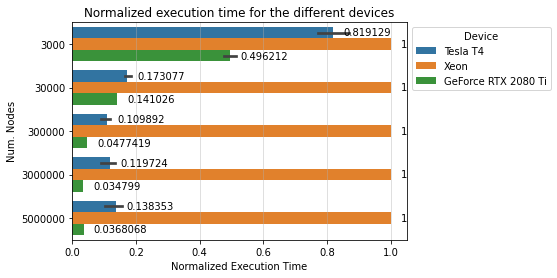

Average speedup CPU vs. GPU: 8.18x


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='r')
ax = sns.barplot(data=table, y='Num. Nodes', x='Normalized Execution Time',
                 hue='Device', orient='h')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
for container in ax.containers:
    ax.bar_label(container, padding=10)
plt.grid(axis='x', alpha=0.5)
plt.title('Normalized execution time for the different devices')
plt.show()

table_gpu = table[table['Device'].isin(['Tesla T4', 'GeForce RTX 2080 Ti'])].copy()
# table_gpu = table[table['Device'] == 'GeForce RTX 2080 Ti'].copy()
table_cpu = table[table['Device'] == 'Xeon'].copy()

cpu_t = table_cpu['Avg. Time [s]']
gpu_t = table_gpu['Avg. Time [s]']
print(f'Average speedup CPU vs. GPU: {cpu_t.mean() / gpu_t.mean():.2f}x')
# print(f'Highest speedup CPU vs. GPU: {cpu_t.max() / gpu_t.max():.2f}x')

As expected, the GPU implementation is clearly superior in terms of performance, being as low as 3% of the CPU time and $8.2\times$ faster than CPU on average, with a peak of $27.2\times$.

If we now investigate how the amount of threads per block influences the performance of the custom kernel, we see a negligible difference, as follows:

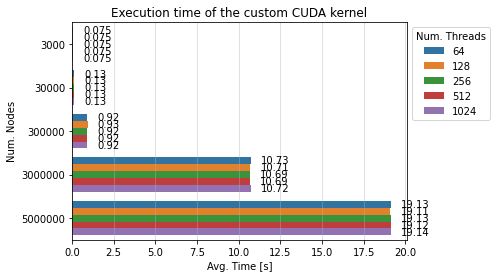

In [ ]:
# figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='r')
table_gpu = table[table['Device'].isin(['Tesla T4', 'GeForce RTX 2080 Ti'])].copy()
table_gpu = table_gpu[table_gpu['Batched/Custom Kernel'] == 'Custom Kernel']

ax = sns.barplot(data=table_gpu, y='Num. Nodes', x='Avg. Time [s]',
                 hue='Num. Threads', orient='h')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
for container in ax.containers:
    ax.bar_label(container, padding=10)
plt.grid(axis='x', alpha=0.5)
plt.title('Execution time of the custom CUDA kernel')
plt.show()

We can now focus on comparing the two proposed GPU versions.

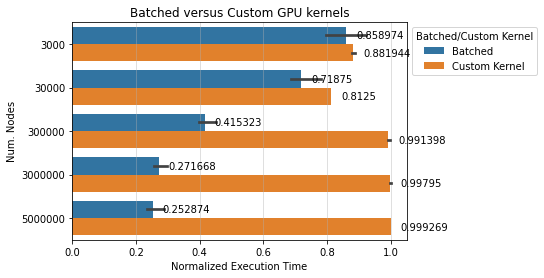

Speedup Batched vs. Custom kernel: 6.56x


In [ ]:
table_gpu = table[table['Device'].isin(['Tesla T4', 'GeForce RTX 2080 Ti'])].copy()
table_gpu['Normalized Execution Time'] = table_gpu['Avg. Time [s]']

for n_cells in table_gpu['Num. Cells'].unique():
    selected_cells = table_gpu['Num. Cells'] == n_cells
    max_t = table_gpu.loc[selected_cells, 'Avg. Time [s]'].max()
    table_gpu.loc[selected_cells, 'Normalized Execution Time'] /= max_t

# figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='r')
ax = sns.barplot(data=table_gpu, y='Num. Nodes', x='Normalized Execution Time',
                 hue='Batched/Custom Kernel', orient='h')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
for container in ax.containers:
    ax.bar_label(container, padding=10)
plt.grid(axis='x', alpha=0.5)
plt.title('Batched versus Custom GPU kernels')
plt.show()

batched_t = table_gpu.loc[table_gpu['Batched/Custom Kernel'] == 'Batched', 'Avg. Time [s]']
custom_t = table_gpu.loc[table_gpu['Batched/Custom Kernel'] == 'Custom Kernel', 'Avg. Time [s]']
print(f'Average speedup Batched vs. Custom kernel: {custom_t.mean() / batched_t.mean():.2f}x')

The batched GPU version is $6.6\times$ faster on average, and the performance gap increases as the number of points increases. This suggests that the custom kernel implementation suffers from an inefficient memory managment.

Finally, we can compare the performance of the two examined GPU devices.

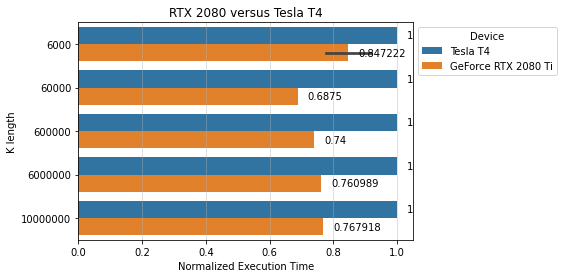

Average speedup T4 vs. RTX: 6.84x


In [ ]:
table_gpu = table[table['Device'].isin(['Tesla T4', 'GeForce RTX 2080 Ti'])].copy()
table_gpu = table_gpu[table_gpu['Batched/Custom Kernel'] == 'Batched']
table_gpu['Normalized Execution Time'] = table_gpu['Avg. Time [s]']

for n_cells in table_gpu['Num. Cells'].unique():
    selected_cells = table_gpu['Num. Cells'] == n_cells
    max_t = table_gpu.loc[selected_cells, 'Avg. Time [s]'].max()
    table_gpu.loc[selected_cells, 'Normalized Execution Time'] /= max_t

# figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='r')
ax = sns.barplot(data=table_gpu, y='Num. Nodes', x='Normalized Execution Time',
                 hue='Device', orient='h')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
for container in ax.containers:
    ax.bar_label(container, padding=10)
plt.grid(axis='x', alpha=0.5)
plt.title('RTX 2080 versus Tesla T4')
plt.show()

tesla_t = table.loc[table['Device'] == 'Tesla T4', 'Avg. Time [s]']
rtx_t = table.loc[table['Device'] == 'GeForce RTX 2080 Ti', 'Avg. Time [s]']
print(f'Average speedup T4 vs. RTX: {tesla_t.mean() / rtx_t.mean():.2f}x')

The RTX card is $6.8\times$ faster on average than the T4 card. This might be due to different GPU architecture characteristcs, such as the number of CUDA cores (2944 in the RTX versus 2560 in the T4) and their core clock speed (around 1500MHz in the RTX versus 585MHz in the T4).

# Conclusions and Future Work

In this work we proposed, designed and implemented different solutions for accelerating the FEM algorithm computation, to be run both in a multithreaded environment and on a GPU card.
In our experiments, we show that the batched implementation is a viable and efficient solution, especially for the GPU case, which allowed us to achieve a top speedup of $28\times$ over the CPU counterpart.

Here is a list of possible future directions that can be explored and analyzed:

* More advanced meshes, such as 3D meshes and/or more DoFs per cell
* Efficient handling of the COO data and exploring and efficiently leverage DOK format to save space, _i.e._, manual implementation of the reduction phase
* More in-depth analysis of the data movement and memory requirements of the algorithm. For example, use of shared memory in the custom kernel might improve its performance. See Numba on [shared memory](https://numba.readthedocs.io/en/stable/cuda/memory.html#shared-memory-and-thread-synchronization), and this [example](https://numba.readthedocs.io/en/stable/cuda/examples.html#cuda-matmul).
* More advanced design space exploration of the custom CUDA kernel parameters
* Analysis of the convergency rate of the solvers at different tolerance levels

# Appendix: Cell Coloring

Cell coloring refers to a K-assembly mechanism in which cells not sharing nodes can be assigned to different color pools. This strategy allows then to update the global stiffness matrix color-wise without race conditions, since we are guaranteed to have non-overlapping updates.

Unfortunately, this has remained a work in progress and it's included for future reference.

## Coloring Strategies

### Graph Partitioning with PyMETIS

Unfortunately PyMETIS, a Python wrapper to the METIS software, is producing colors with "overlapping" elements. Because of that, it is not possibile to use it as a partitioning algorithm.

In [ ]:
%%capture
!pip install pymetis

In [ ]:
import pymetis

In [ ]:
from collections import defaultdict

def create_adjacency_list_naive(cells):
    # Create a defaultdict to store the adjacency
    adjacency = defaultdict(set)
    # Iterate through each cell in the graph
    for i, cell in enumerate(cells):
        for j, other_cell in enumerate(cells):
            if set(cell).isdisjoint(other_cell):
                if i != j:
                    adjacency[i].add(j)
    return adjacency

def create_adjacency_list(cells):
    # Create a defaultdict to store the cells that include a given node
    node2cell = defaultdict(set)
    for i, cell in enumerate(cells):
        for node in cell:
            node2cell[node].add(i)
    cells_set = set(list(range(len(cells))))
    # Create a defaultdict to store the adjacency
    adjacency = defaultdict(set)
    # Iterate through each cell in the graph
    for i, cell in enumerate(cells):
        nodes = set([c for node in cell for c in node2cell[node]])
        adjacency[i].update(cells_set.difference(nodes))
    return adjacency

# Example usage
grid = generate_grid(lcar=0.4)
adjacency = create_adjacency_list(grid.cells)
adjacency_naive = create_adjacency_list_naive(grid.cells)

for k in adjacency_naive.keys():
    # list(adjacency[k]).sort() 
    # list(adjacency_naive[k]).sort()
    if adjacency_naive[k] != adjacency[k]:
        # print(f'not matching: {adjacency[k]} vs. {adjacency_naive[k]}')
        print('MISMATCH!!!', adjacency[k] - adjacency_naive[k])
        if k > 10:
            break

In [ ]:
grid = generate_grid(lcar=0.8)
n_parts = 16
# adjacency = create_adjacency_list(grid.cells)
adjacency = create_adjacency_list_naive(grid.cells)

n_cuts, membership = pymetis.part_graph(n_parts, adjacency=adjacency)

print(f'n_nodes: {grid.get_num_cells() * grid.get_num_nodes_per_cell()}')
print(f'n_cells: {grid.get_num_cells()} (n_parts: {n_parts}) - Cells per part: {(grid.get_num_cells() / n_parts) / grid.get_num_cells() * 100}%')
print(f'n_cuts: {n_cuts}')
print('-' * 80)

for part in range(n_parts):
    cells_part = np.argwhere(np.array(membership) == part).ravel()

    nodes_idx_part = grid.cells[cells_part].flatten()
    unique_nodes_idx_part = np.unique(nodes_idx_part)

    if len(nodes_idx_part) != len(unique_nodes_idx_part):
        nodes_part = grid.nodes[unique_nodes_idx_part]
        nodes_idx_part.sort()
        unique_nodes_idx_part.sort()
        print(part, len(nodes_idx_part), nodes_idx_part)
        print(part, len(unique_nodes_idx_part), unique_nodes_idx_part)
        print(part, len(nodes_idx_part) - len(unique_nodes_idx_part))
        nodal_values = np.random.randn(len(nodes_part))
        nodes_x = grid.nodes[:, 0]
        nodes_y = grid.nodes[:, 1]
        # Plot the finite element mesh
        for element in grid.cells[cells_part]:
            x = [nodes_x[element[i]] for i in range(len(element))]
            y = [nodes_y[element[i]] for i in range(len(element))]
            plt.fill(x, y, edgecolor='black', fill=True)
        plt.axis('equal')
        plt.show()
        print('-' * 80)

In [ ]:
def color_cells(grid, n_colors=64):
    """
    The returned partitions are already sorted (being sorted should help a bit
    with cache locality...).
    """
    adjacency = create_adjacency_list(grid.cells)
    _, membership = pymetis.part_graph(n_colors, adjacency=adjacency)
    partitions = []
    for color in range(n_colors):
        cellids_part = np.argwhere(np.array(membership) == color).flatten()
        if len(cellids_part) > 0:
            partitions.append(cellids_part)
            # Check whether the nodes in the partition are all unique, and so
            # non-overlapping

            # nodes_part = grid.cells[cellids_part].flatten()
            # unique_nodes_idx = np.unique(nodes_part)
            # unique_nodes_part = grid.nodes[unique_nodes_idx]

            nodes_idx_part = grid.cells[cellids_part].flatten()
            unique_nodes_idx_part = np.unique(nodes_idx_part)
            # nodes_part = grid.nodes[unique_nodes_idx_part]
            # nodes_idx_part.sort()
            # unique_nodes_idx_part.sort()
            # if len(nodes_part) != len(unique_nodes_part):
            if len(nodes_idx_part) != len(unique_nodes_idx_part):
                if color != n_colors - 1:
                    # raise ValueError('Overlapping nodes in two or more partitions.')
                    print(f'WARNING. Overlapping nodes in partition n.{color}.')
                else:
                    print(f'WARNING. Overlapping nodes in last partition.')
    return partitions

grid = generate_grid(lcar=0.6)
color_cells(grid, n_colors=8)

WARNING. Overlapping nodes in partition n.2.
WARNING. Overlapping nodes in partition n.5.


[array([ 1, 11, 19, 21, 28, 40, 61, 73, 76]),
 array([ 5,  7,  9, 18, 23, 38, 48, 56, 59, 67]),
 array([13, 16, 17, 22, 30, 31, 35, 68, 74]),
 array([ 4, 41, 43, 52, 53, 57, 58, 60, 62, 66]),
 array([ 2,  6, 10, 12, 24, 29, 46, 49, 70]),
 array([27, 33, 39, 42, 47, 51, 54, 65, 69, 75]),
 array([ 0, 15, 20, 25, 26, 32, 37, 44, 45, 71, 72]),
 array([ 3,  8, 14, 34, 36, 50, 55, 63, 64])]

### Naive Greedy Coloring Algorithm

Greedy Coloring Algorithm, as described in these [lecture notes](http://paulino.princeton.edu/education_resources/GreedyColoring/GreedyColoring.pdf)):

0. Set the maximum color size, _e.g._, according to the number of threads available
1. Get the next element in the mesh
2. Traverse all its neighbors, and see what colors cannot be used
3. Pick the next available color
4. If color is already full, go to 3
5. Color this element with this color
6. If this is not the last element, go to 1

The greatest advantage of this coloring algorithm is that the colors will have at most $N$ elements, making is suitable to precisely map colors to GPU resources.

In [ ]:
from collections import defaultdict

grid = generate_grid(lcar=0.6)
cells = grid.cells

# Create a defaultdict to store the all cells to which a given node belongs to
node2cell = defaultdict(set)
for i, cell in enumerate(cells):
    for node in cell:
        node2cell[node].add(i)
cell_neighbors = defaultdict(set)
for i, cell in enumerate(cells):
    for node in cell:
        neighbors = node2cell[node] - {i} # Do not include the cell itself
        cell_neighbors[i].update(neighbors)
# # Init first element color
# cells_colors = {0: 0} # {Cellid n.0: color n.0}
# n_colors = 1
# for i, cell in enumerate(cells):
#     if i == 0:
#         continue

#     neighbors_colors = [cells_colors[neighbor] for neighbor in cell_neighbors[i] if neighbor in cells_colors]
#     # for neighbor in cell_neighbors[i]:

#     #     for neighbor_id in neighbors:
#     #         neighbor_color = neighbors_colors[neighbor_id]


# # cells_set = set(list(range(len(cells))))
# # # Create a defaultdict to store the adjacency
# # adjacency = defaultdict(set)
# # # Iterate through each cell in the graph
# # for i, cell in enumerate(cells):
# #     nodes = set([c for node in cell for c in node2cell[node]])
# #     adjacency[i].update(cells_set.difference(nodes))
# # # return adjacency

### Greedy Coloring via NetworkX

Coloring via NetworkX is fast and effective, but doesn't ensure that each color will contain a constant number of elements. Because of this, each color might have a different number of elements, eventually causing GPU under-utilization.

In [ ]:
from collections import defaultdict

@nb.jit(nopython=False)
def get_neighbors(cells):
    # Create a dict to store the all cells to which a given node belongs to
    node2cell = defaultdict(set)
    for i, cell in enumerate(cells):
        for node in cell:
            node2cell[node].add(i)
    cell_neighbors = defaultdict(set)
    for i, cell in enumerate(cells):
        for node in cell:
            neighbors = node2cell[node] - {i} # Do not include the cell itself
            cell_neighbors[i].update(neighbors)
    return cell_neighbors

In [ ]:
%%capture
import networkx as nx

grid = generate_grid(lcar=0.5)

def color_cells(cells):
    cell_neighbors = get_neighbors(cells)
    coloring = nx.greedy_color(nx.Graph(cell_neighbors))
    colored_cells = np.array(list(coloring.keys()))
    colors = np.array(list(coloring.values()))
    n_colors = colors.max() + 1
    partitions = []
    for color in range(n_colors):
        partition = colored_cells[colors == color]
        # print(f'cells in color n.{color}: {len(partition)}')
        partitions.append(partition)
    return partitions

color_cells(grid.cells)

## Colored FEM on GPU

In [ ]:
K, f, a, weak_form, dh, dofs_glob = generate_fem_problem(lcar=0.04, as_dok=True)
print(f'Number of cells: {len(dh.grid.cells)}')
print(f'Number of nodes: {len(dh.grid.cells) * dh.grid.get_num_nodes_per_cell()}')
print(f'K dimensions: {K.shape} (total: {math.prod(K.shape)})')

Number of cells: 13488
Number of nodes: 40464
K dimensions: (13830, 13830) (total: 191268900)


In [ ]:
@nb.jit(nopython=True)
def get_Kf_entries(K, f, dofs, ke, re):
    """
    Populate ke and re entries from K and f based on dofs

    dofs: shape: (block_sz, n_dofs_per_cell)
    ke: shape: (block_sz, n_dofs_per_cell, n_dofs_per_cell)
    re: shape: (block_sz, n_dofs_per_cell)
    """
    color_sz = dofs.shape[0]
    for k in range(color_sz):
        for i, dof_i in enumerate(dofs[k]):
            re[k, i] = f[dof_i]
            for j, dof_j in enumerate(dofs[k]):
                ke[k, i, j] = K.get((dof_i, dof_j), float32(0))

@nb.jit(nopython=True)
def set_Kf_entries(ke, re, dofs, K, f):
    """
    Update K and f from ke and re based on dofs

    ke: shape: (block_sz, n_dofs_per_cell, n_dofs_per_cell)
    re: shape: (block_sz, n_dofs_per_cell)
    dofs: shape: (block_sz, n_dofs_per_cell)
    """
    color_sz = dofs.shape[0]
    for k in range(color_sz):
        for i, dof_i in enumerate(dofs[k]):
            f[dof_i] = re[k, i]
            for j, dof_j in enumerate(dofs[k]):
                K[(dof_i, dof_j)] = ke[k, i, j]

@nb.jit(nopython=True)
def get_coo_matrix_components(Knumba):
    nnz = len(Knumba)
    data = np.empty(nnz, dtype=np.float32)
    rows = np.empty(nnz, dtype=np.int32)
    cols = np.empty(nnz, dtype=np.int32)
    for k, (i, j) in enumerate(Knumba.keys()):
        data[k] = Knumba[(i, j)]
        rows[k] = i
        cols[k] = j
    return data, rows, cols

def colored_k_assembly_gpu(K, f, a, weak_form, dh, return_numba_dict=False):
    n_cells = dh.grid.get_num_cells()
    n_dims = dh.grid.n_dim
    n_dofs_cell = dh.ndofs_per_cell(dh.grid)
    n_nodes_cell = dh.grid.nnodes_per_cell()
    # Partition/color the cells
    cellids_partitions = color_cells(dh.grid.cells)
    color_sz = max([len(i) for i in cellids_partitions])
    # Specify CUDA kernel dimensions
    threadsperblock = 128
    blockspergrid = (color_sz + (threadsperblock - 1)) // threadsperblock
    # Init local variables for element loop (re-use them across iterations)
    dofs = np.empty((color_sz, n_dofs_cell), dtype=np.int32)
    xe = np.empty((color_sz, n_nodes_cell, n_dims), dtype=np.float32) 
    ue = np.empty((color_sz, n_dofs_cell), dtype=np.float32)
    ke = np.zeros((color_sz, n_dofs_cell, n_dofs_cell), dtype=np.float32)
    re = np.zeros((color_sz, n_dofs_cell), dtype=np.float32)
    # Move to device the following data once for all colors
    stiffness_d = cuda.to_device(weak_form.material.stiffness)
    weights_d = cuda.to_device(weak_form.element.weights)
    # The Dict.empty() constructs a typed dictionary required in Numba
    Knumba = Dict.empty(
        key_type=types.UniTuple(types.int32, 2),
        value_type=types.float32,
    )
    # Loop over colors, fill GPU buffers and finally accumulate
    for color, cellids in enumerate(cellids_partitions):
        # Setup kernel inputs
        dofs.fill(0)
        xe.fill(0)
        ue.fill(0)
        xe = dh.grid.nodes[dh.grid.cells[cellids]]
        # NOTE: The methods dh.grid.get_coordinates() and dh.get_cell_dofs() are
        # implemented in Numba to handle multi-dimensional indexing
        get_dofs(dh.grid.cells[cellids], a, dofs, ue)
        xe_d = cuda.to_device(xe)
        ue_d = cuda.to_device(ue)
        # Setup kernel input-outputs (ke and re are accumulated)
        get_Kf_entries(Knumba, f, dofs, ke, re)
        re_d = cuda.to_device(re)
        ke_d = cuda.to_device(ke)
        # Run kernel
        elem_routine_kernel[blockspergrid, threadsperblock](weak_form.thickness,
            stiffness_d, weights_d, xe_d, ue_d, re_d, ke_d)
        # Retrieve data from device
        re = re_d.copy_to_host()
        ke = ke_d.copy_to_host()
        # Update Knumba and f components
        set_Kf_entries(ke, re, dofs, Knumba, f)
    if return_numba_dict:
        return Knumba, f
    else:
        # Transform Numba matrix into Scipy sparse matrix in COO-format
        data, rows, cols = get_coo_matrix_components(Knumba)
        K = coo_matrix((data, (rows, cols)), dtype=np.float32).todok()
        return K, f

K_gpu, f_gpu = colored_k_assembly_gpu(K, f, a, weak_form, dh)
print(f'K dimensions: {K_gpu.shape} (total: {math.prod(K_gpu.shape)}, nnz: {K_gpu.nnz})')
K_gpu

In [ ]:
plt.spy(K_gpu)
plt.show()

In [ ]:
K_free = K_gpu.tocsc()[:, dofs_glob['free']].tocsr()[dofs_glob['free'], :]
K_prescribed = K_gpu.tocsc()[:, dofs_glob['prescribed']].tocsr()[dofs_glob['free'], :]
f_glob = -K_prescribed @ a[dofs_glob['prescribed']]
scipy.sparse.linalg.minres(K_free, f_glob)

# Converting Notebook to PDF

The following two cells can be ignored for grading, as they just convert this notebook into a PDF file.

In [ ]:
%%capture
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic
!apt-get install -y inkscape
!add-apt-repository -y universe
!add-apt-repository -y ppa:inkscape.dev/stable
!apt-get update -y
!apt install -y inkscape

In [ ]:
%%capture
import os
import re

document_name = 'TRA105 GPU-accelerated Computational Methods using Python and CUDA'
pdf_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
pdf_dir = os.path.join(pdf_dir, 'Colab Notebooks', 'tra105')
pdf_filename = re.escape(os.path.join(pdf_dir, document_name)) + '.ipynb'

!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=False $pdf_filename